In [81]:
%matplotlib inline
import matplotlib.pylab as plt
from trade_signal import *
from stratege.ma import *
from stratege.dummy import *
from stratege.close_stratege import *
from stratege.breakthrough import *
from signal_by_wave import *
from talib.abstract import *

In [3]:
# market = pd.read_csv("~/cs_market.csv", parse_dates=["date"], dtype={"code": str})

market = pd.read_csv("E:\market_data/cs_market.csv", parse_dates=["date"], dtype={"code": str})

ohlcv = market.drop(["Unnamed: 0", "total_turnover", "limit_up", "limit_down"], axis=1)

ohlcv = ohlcv.set_index('date')


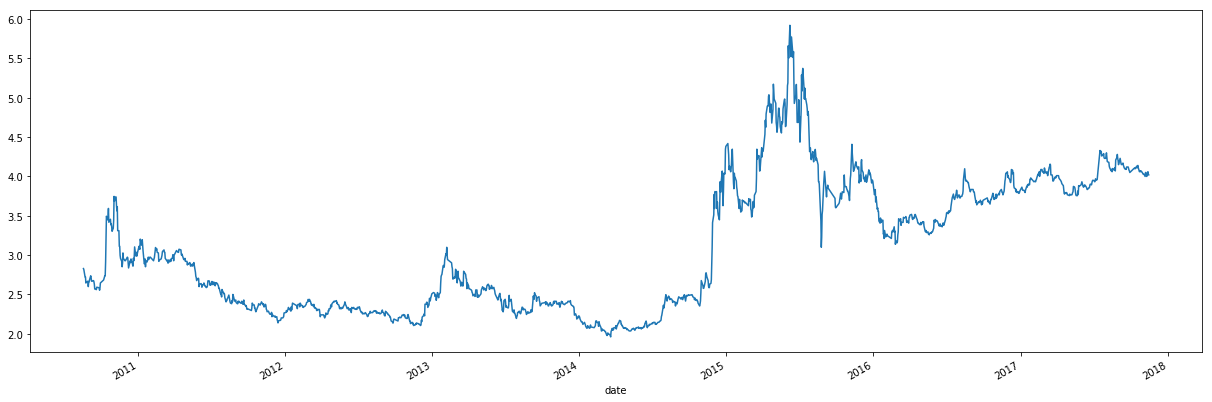

In [4]:
zz500 = ohlcv[ohlcv["code"] == "601818.XSHG"].drop("code", axis=1)

zz500['close'].plot(figsize=(21, 7))

In [ ]:
zz500.iloc[0:1]['close'].values

In [ ]:
# f_double_ma_signal = double_ma_stratege(zz500, 5, 30)
f_signal_by_wave = signal_by_wave(zz500, 30, 0.05)
# f_break_extreme_signal = break_extremal_point(zz500)
# i_double_ma_signal = signal_full2increment(f_break_extreme_signal)
i_signal_by_wave = signal_full2increment(f_signal_by_wave)

In [ ]:
# signal_compare = pd.DataFrame(index=f_double_ma_signal.index)
signal_compare = pd.concat([f_signal_by_wave, i_signal_by_wave], axis=1)
signal_compare.columns = ['full', 'increment']
signal_compare.plot(figsize=(21, 7))

In [ ]:
zz500.head()

In [ ]:
open_signal = i_signal_by_wave
ohlcv = zz500
close_signal = close_signal_generate(ohlcv, open_signal, close_MaxLoss_ATR, loss_pct=0.03, atr_times=1, atr_timeperiod=10)

In [ ]:
signal_compare['close_signal'] = close_signal

In [ ]:
signal_compare.fillna(0).plot(figsize=(21, 7))

In [ ]:
price_signal = pd.concat([ohlcv['close'], signal_compare['increment'], signal_compare['close_signal']], axis=1)

In [ ]:
price_signal = price_signal.reset_index()
price_signal = price_signal.reset_index()

In [ ]:
fig, ax = plt.subplots(1, figsize=(21, 7))
price_signal.plot(x='index', y='close', figsize=(21, 7), ax=ax)
price_signal[price_signal['increment']>0].plot.scatter(x='index', y='close', s=30, c='r', figsize=(21, 7), ax=ax)
price_signal[price_signal['close_signal']<0].plot.scatter(x='index', y='close', s=30, c='g', figsize=(21, 7), ax=ax)

In [5]:
def angle_degree(x, y):
    return np.arctan2(x, y)


def acceleration(alpha, drag_ratio):
    a = np.sin(alpha) - np.cos(alpha) * drag_ratio
    return a


def velocity(v0, a, s):
    vt_square = np.square(v0) + 2 * a * s
    if vt_square < 0:
        vt = 0
    else:
        vt = np.sqrt(vt_square)
    return vt


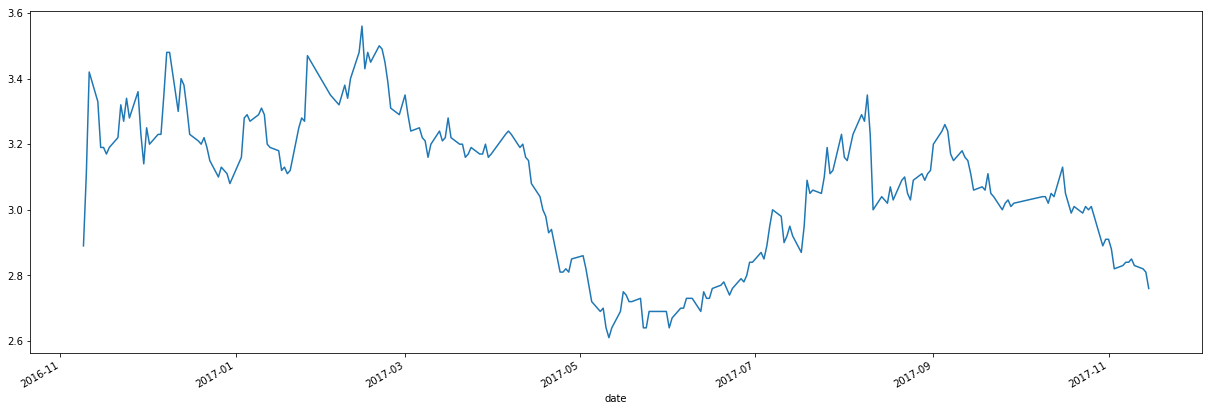

In [60]:
zz500 = ohlcv[ohlcv["code"] == "000630.XSHE"].drop("code", axis=1).tail(250)
zz500['close'].plot(figsize=(21, 7))

In [61]:
zz500['close'] = zz500['close'].rolling(2).mean()
pct_change = (zz500['close'] / zz500['close'].shift(1) - 1).fillna(0)
pct_change.name = "pct_chg"

In [62]:
test = pd.concat([zz500['close'], pct_change], axis=1)

In [63]:
degree = 20
v_init_timeperiod = 2
v_threshod = 1.2
window = 6

In [64]:
std = pct_change.std()
drag_ratio = np.tan(np.pi * degree / 360)
v_init = np.sqrt(2 * drag_ratio * std * v_init_timeperiod)
v0 = v_init

In [65]:
# test1 = test.copy()
# test1['result'] = np.nan
# for idx, row in test1.iterrows():
#     alpha = angle_degree(row['pct_chg'], std)
#     a = acceleration(alpha, drag_ratio)
#     s = std if alpha==0 else std/np.cos(alpha)
#     vt = velocity(v0, a, s)
#     if vt > v_threshod * v_init:
#         test1.loc[idx, 'result'] = 1
#         v0 = vt
#     elif vt > 0:
#         test1.loc[idx, 'result'] = 0
#         v0 = vt
#     else:
#         v0 = v_init
#         test1.loc[idx, 'result'] = -1

In [66]:
hights = np.array([1, 2, 3, 4])

In [67]:
my_cum_velocity = cum_velocity_bind(std, v_init, drag_ratio)

In [68]:
def cum_velocity(hights, length, v_init, drag_ratio):
    v0 = v_init
    for i in range(len(hights)):
        alpha = angle_degree(hights[i], length)
        a = acceleration(alpha, drag_ratio)
        s = length/np.cos(alpha)
        vt = velocity(v0, a, s)
        if vt > 0:
            v0 = vt
        else:
            vt = 0
            break
    return vt

In [69]:
def cum_velocity_bind(length, v_init, drag_ratio):
    def cum_velocity_hights(hights):
        return cum_velocity(hights, length, v_init, drag_ratio)
    return cum_velocity_hights

In [70]:
test1 = test.copy()
test1['result'] = np.nan

In [71]:
test1.head()

,close,pct_chg,result
date,,,
2016-11-09,NaN,0.000000,NaN
2016-11-10,3.000,0.000000,NaN
2016-11-11,3.265,0.088333,NaN
2016-11-14,3.375,0.033691,NaN
2016-11-15,3.260,-0.034074,NaN


In [75]:
test1['result'] = test1['pct_chg'].rolling(2).apply(my_cum_velocity)

In [76]:
test1 = test1.reset_index().reset_index()
test1.head()

ValueError: cannot insert level_0, already exists

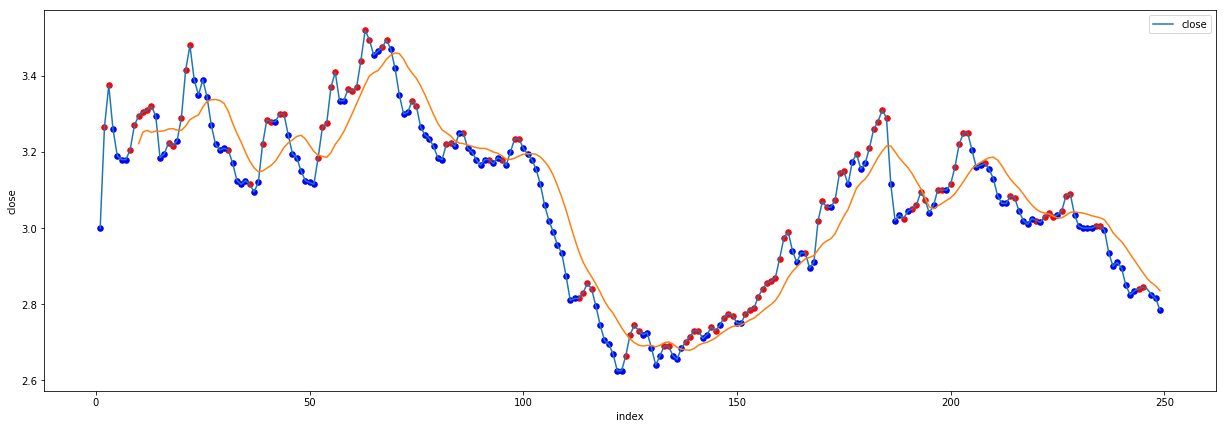

In [91]:
fig, ax = plt.subplots(1, figsize=(21, 7))
test1.plot(x='index', y='close', figsize=(21, 7), ax=ax)
test1['close'].rolling(10).mean().plot(ax=ax)
# BBANDS(test).plot(ax=ax)
test1[test1['result']>0].shift(1).plot.scatter(x='index', y='close', s=30, c='r', figsize=(21, 7), ax=ax)
test1[test1['result']==0].plot.scatter(x='index', y='close', s=30, c='b', figsize=(21, 7), ax=ax)
# test1[test1['result']<0].plot.scatter(x='index', y='close', s=30, c='g', figsize=(21, 7), ax=ax)

In [89]:
for idx in range(len(test1)):
    if idx < window:
        continue
    v0 = v_init
    for i in range(-window, 0):
        alpha = angle_degree(test1.iloc[idx+i]['pct_chg'], std)
        a = acceleration(alpha, drag_ratio)
        s = std if alpha==0 else std/np.cos(alpha)
        vt = velocity(v0, a, s)
        if vt > 0:
            v0 = vt
        else:
            v0 = v_init
        
    if vt > v_threshod * v_init:
        test1.loc[test1.index.values[idx]]['result'] = 1
    elif vt > 0:
        test1.loc[test1.index.values[idx]]['result'] = 0
    else:
        test1.loc[test1.index.values[idx]]['result'] = -1

In [90]:
test1 = test1.reset_index().reset_index()
test.head()

,close,pct_chg
date,,
2016-11-09,NaN,0.000000
2016-11-10,29.40725,0.000000
2016-11-11,30.53145,0.038229
2016-11-14,31.12080,0.019303
2016-11-15,30.57110,-0.017663


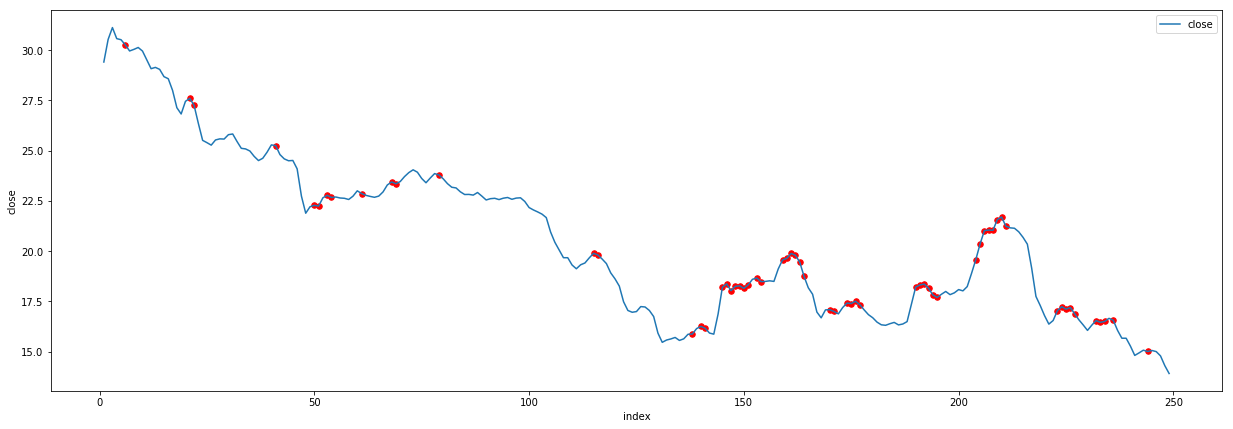

In [91]:
fig, ax = plt.subplots(1, figsize=(21, 7))
test1.plot(x='index', y='close', figsize=(21, 7), ax=ax)
test1[test1['result']>0].plot.scatter(x='index', y='close', s=30, c='r', figsize=(21, 7), ax=ax)
# test1[test1['result']==0].plot.scatter(x='index', y='close', s=30, c='b', figsize=(21, 7), ax=ax)
# test1[test1['result']<0].plot.scatter(x='index', y='close', s=30, c='g', figsize=(21, 7), ax=ax)

In [120]:
import numpy as np

max_return_threshold = 0.1
return_per_count_threshold = 0.002
withdraw_threshold = 0.03
i = 0


def tag_wave_direction(ohlcv, max_return_threshold, return_per_count_threshold, withdraw_threshold):
    ohlcv['direction'] = np.nan
    i = 0
    while i < len(ohlcv):
        # 波段保护的周期数量
        count = 1
        price = ohlcv.iloc[i]['open']
        if ohlcv.iloc[i]['close'] > ohlcv.iloc[i]['open']:
            direction = 1
        elif ohlcv.iloc[i]['close'] < ohlcv.iloc[i]['open']:
            direction = -1
        else:
            i += 1
            continue

        min_price = price
        max_price = price
        argmin = i
        argmax = i
        j = i + 1
        while j < len(ohlcv):
            count += 1
            new_price = ohlcv.iloc[j]['close']

            if new_price > max_price:
                max_price = new_price
                argmax = j

            if new_price < min_price:
                min_price = new_price
                argmin = j

            returns = (new_price / price - 1) * direction
            return_per_count = returns / count

            if direction == 1:
                max_return = (max_price / price - 1)
                withdraw = (max_price - new_price) / price
            elif direction == -1:
                max_return = (1 - min_price / price)
                withdraw = (new_price - min_price) / price
            else:
                max_return = 0
                withdraw = 0

            # 波段趋势太小，未满足return_per_count_threshold
            if return_per_count < return_per_count_threshold:
                i += 1
            break

        # 波段因为最大回撤结束
        if withdraw > withdraw_threshold:
            # 波段太小，未满足max_return_threshold
            if max_return < max_return_threshold:
                i += 1
                break
            else:
                if direction == 1:
                    max_return_pos = argmax
                elif direction == -1:
                    max_return_pos = argmin
                else:
                    i += 1
                    break
                # 标记[i, max_return_pos]的direction标签
                for k in range(i, max_return_pos + 1):
                    ohlcv.iloc[k]['direction'] = direction
                    i = max_return_pos + 1
                    break
        else:
            # 未达到最大回撤
            continue
    return ohlcv

In [117]:
d = tag_wave_direction(xx, 0.1, 0.01, 0.03)

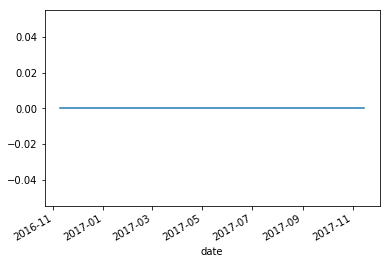

In [119]:
d['direction'].fillna(0).plot()